In [1]:
from metaflow import Flow, get_metadata, namespace
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import ndimage
from pyLDAvis.gensim import prepare
import pyLDAvis
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('fivethirtyeight')
sns.set()
pyLDAvis.enable_notebook()

In [2]:
!python lda_jensen_shannon.py show

Metaflow 2.0.5 executing LDAJensenShannonFlow for user:dev

Use an LDA components analysis for text documents and then evaluate their
similarities using Jensen-Shannon Distance

1. Loading data
2. Treating Data
3. Generating LDA Component Analysis
    3.1 Finding Optimal Number of Components
    3.2 Generating Topics
4. Similarity Jensen-Shannon
    4.1 Creating Topics Similarities Pairs
    4.2 Generating Heatmap for Text Similarities
5. Bibliography

Step start
    Load preprocessed documents
    => selecting_number_components

Step selecting_number_components
    Using the elbow curve analysis.
    In this analysis we try models from an interval of topics numbers
    and using each model's topics coherence values to score them.
    => generating_topics

Step generating_topics
    Generate topics and describe documents based
    on how much they fit in each topic.
    => generating_text_pairs

Step generating_text_pairs
    Create a new dataframe with pair of documents. If the given


In [3]:
!python lda_jensen_shannon.py --no-pylint run --tag visualisation --num_samples 100
!python lda_jensen_shannon.py --no-pylint run --tag performance --num_samples 1000

Metaflow 2.0.5 executing LDAJensenShannonFlow for user:dev
Validating your flow...
    The graph looks good!
2020-06-08 18:41:09.075 Workflow starting (run-id 1591652469068240):
2020-06-08 18:41:09.078 [1591652469068240/start/1 (pid 11465)] Task is starting.
2020-06-08 18:41:13.377 [1591652469068240/start/1 (pid 11465)] Task finished successfully.
2020-06-08 18:41:13.381 [1591652469068240/selecting_number_components/2 (pid 11472)] Task is starting.
2020-06-08 18:41:28.344 [1591652469068240/selecting_number_components/2 (pid 11472)] Task finished successfully.
2020-06-08 18:41:28.348 [1591652469068240/generating_topics/3 (pid 11479)] Task is starting.
2020-06-08 18:41:29.760 [1591652469068240/generating_topics/3 (pid 11479)] Task finished successfully.
2020-06-08 18:41:29.764 [1591652469068240/generating_text_pairs/4 (pid 11486)] Task is starting.
2020-06-08 18:41:32.208 [1591652469068240/generating_text_pairs/4 (pid 11486)] Task finished successfully.
2020-06-08 18:41:32.211 [159165246

In [4]:
visualisation_run = list(Flow('LDAJensenShannonFlow').runs('visualisation'))[0]
performance_run = list(Flow('LDAJensenShannonFlow').runs('performance'))[0]
print("Using runs: ", str(visualisation_run), str(performance_run))

Using runs:  Run('LDAJensenShannonFlow/1591652469068240') Run('LDAJensenShannonFlow/1591652496966339')


In [12]:
mapped_distances_df = visualisation_run.data.mapped_distances_df

coherence_values = performance_run.data.coherence_values
best_model = performance_run.data.lda_model
doc_term_matrix = performance_run.data.doc_term_matrix
dictionary = performance_run.data.dictionary
minimum_number_components = performance_run.data.minimum_number_components
maximum_number_components = performance_run.data.maximum_number_components
performance_mapped_distances = performance_run.data.mapped_distances_df
performance_mapped_predictions = performance_run.data.mapped_predictions_df
total_time = performance_run.data.total_time
mapped_distances_df

,1035663,312760613,2252620,3249039,4927062,3212563,2551706,308782615,185820350,308960860,...,2408091,311532392,311565908,311631570,313243611,311726081,310117018,311866620,311925109,311726187
1035663,1.000000,0.971168,0.968180,0.960461,0.921095,0.902859,0.877289,0.872635,0.869068,0.849021,...,0.167445,0.167445,0.167445,0.167445,0.167445,0.167445,0.167445,0.167445,0.167445,0.167445
312760613,0.971168,1.000000,0.939377,0.931670,0.892389,0.931579,0.905920,0.856481,0.897665,0.877522,...,0.167445,0.167445,0.167445,0.167445,0.167445,0.167445,0.167445,0.167445,0.167445,0.167445
2252620,0.968180,0.939377,1.000000,0.992276,0.952855,0.871260,0.845810,0.884789,0.837634,0.817712,...,0.167445,0.167445,0.167445,0.167445,0.167445,0.167445,0.167445,0.167445,0.167445,0.167445
3249039,0.960461,0.931670,0.992276,1.000000,0.960572,0.863609,0.838192,0.886611,0.830028,0.810138,...,0.167445,0.167445,0.167445,0.167445,0.167445,0.167445,0.167445,0.167445,0.167445,0.167445
4927062,0.921095,0.892389,0.952855,0.960572,1.000000,0.824673,0.799442,0.887944,0.791345,0.771634,...,0.167445,0.167445,0.167445,0.167445,0.167445,0.167445,0.167445,0.167445,0.167445,0.167445
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311726081,0.167445,0.167445,0.167445,0.167445,0.167445,0.167445,0.167445,0.214786,0.167445,0.167445,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
310117018,0.167445,0.167445,0.167445,0.167445,0.167445,0.167445,0.167445,0.214786,0.167445,0.167445,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
311866620,0.167445,0.167445,0.167445,0.167445,0.167445,0.167445,0.167445,0.214786,0.167445,0.167445,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
311925109,0.167445,0.167445,0.167445,0.167445,0.167445,0.167445,0.167445,0.214786,0.167445,0.167445,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


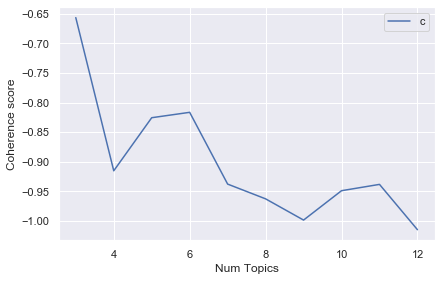

In [13]:
# Show graph
x = range(minimum_number_components, maximum_number_components+1)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

### 3.2 Generating Topics

In [14]:
vis = prepare(best_model, doc_term_matrix, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.015587 -0.096268       1        1  56.660797
2     -0.099488  0.058624       2        1  24.712622
0      0.115075  0.037644       3        1  18.626587, topic_info=               Term         Freq        Total Category  logprob  loglift
2239        fazenda  2140.000000  2140.000000  Default  30.0000  30.0000
2526   contribuicao  1880.000000  1880.000000  Default  29.0000  29.0000
647        nacional  2161.000000  2161.000000  Default  28.0000  28.0000
2619  contribuicoes  1343.000000  1343.000000  Default  27.0000  27.0000
870      tributario  1237.000000  1237.000000  Default  26.0000  26.0000
...             ...          ...          ...      ...      ...      ...
329            fato   387.582977  1084.020630   Topic3  -5.6507   0.6521
607        original   403.288239  1367.086670   Topic3  -5.6110   0.4598
1830   procuradoria   425.796387  1886.999390   Topic3  -5.5567   0.1918
64        documento   392.349518  1611.534546   Topic3  -5.6385   0.2678
48          decisao   388.494751  2870.800293   Topic3  -5.6484  -0.3195

[261 rows x 6 columns], token_table=      Topic      Freq             Term
term                                  
2879      2  0.997900    ST_ARTIGO_149
2879      3  0.002146    ST_ARTIGO_149
3394      1  0.051006    ST_ARTIGO_170
3394      3  0.949987    ST_ARTIGO_170
2880      1  0.001971    ST_ARTIGO_195
...     ...       ...              ...
178       2  0.791610          usuario
178       3  0.059970          usuario
3008      2  0.995263          valorem
179       1  0.990902  vicepresidencia
179       3  0.009008  vicepresidencia

[506 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1])

### 4.2 Generating Heatmap for Text Similarities

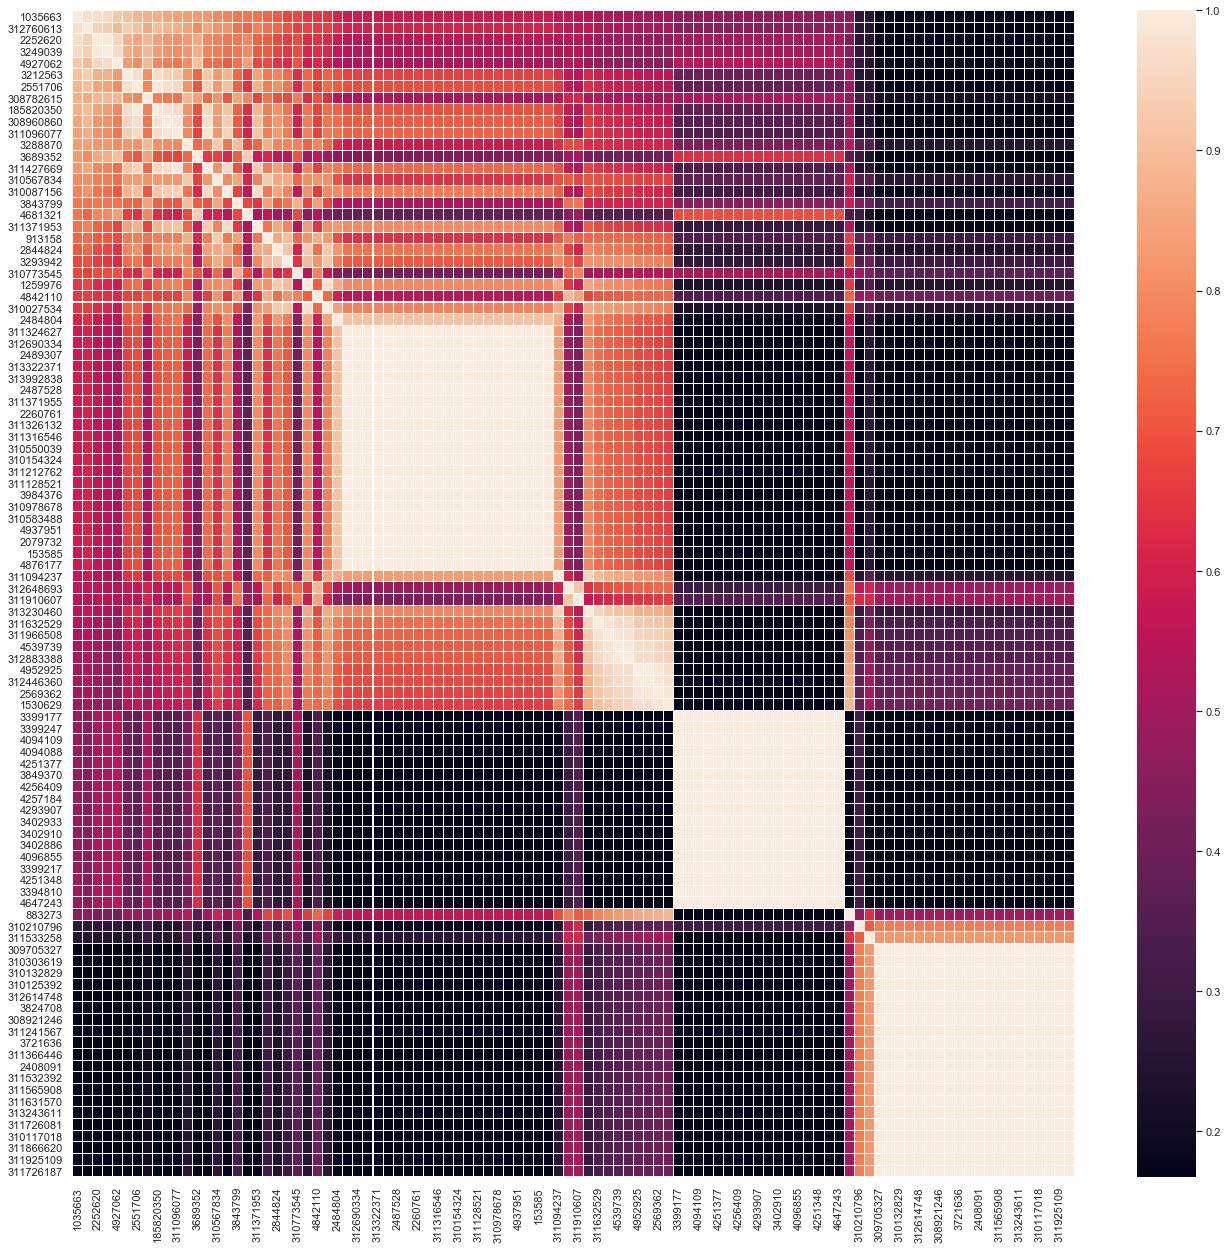

In [8]:
plt.figure(figsize=(20, 20))
ax = sns.heatmap(mapped_distances_df, linewidths=0.01)

# 4. Evaluation

## 4.1 Time Consumed

In [9]:
print("Tempo consumido foi: ", total_time)

Tempo consumido foi:  0:12:07.828210


## 4.2 Similarities Surface
 If we analyses the similarities as if it was a surface we can measure how smooth they change. If the smoothness is high, the less informative the algorithm is to differentiate documents

In [10]:
result = ndimage.laplace(mapped_distances_df.to_numpy())
surface_roughness = np.average(np.absolute(result))
print("Surface Smoothness(0 to 1): ", 1 - surface_roughness)

Surface Smoothness(0 to 1):  0.8411881750413287


## Using Similarities To Classify

In [11]:
predictions_matrix = performance_mapped_predictions.to_numpy()

true_positive = 0
true_negative = 0
false_positive = 0
false_negative = 0
count = 0
for i in range(1, len(predictions_matrix)):
    for j in range(i, len(predictions_matrix)):
        count += 1
        similarity_prediction, true_class = predictions_matrix[i][j]
        if similarity_prediction == true_class:
            if similarity_prediction:
                true_positive += 1
            else:
                true_negative += 1
        else:
            if similarity_prediction:
                false_positive += 1
            else:
                false_negative += 1

accuracy = (true_positive + true_negative)/(true_positive + false_positive + true_negative + false_positive)
precision = true_positive/(true_positive + false_positive)
recall = true_positive/(true_positive + false_negative)
f1_score = 2*(recall * precision)/(recall+precision)
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1_score)

Accuracy:  0.47595463022409734
Precision:  0.5004080443019527
Recall:  0.5480138527585822
F1 Score:  0.5231301274385087


# 5. Bibliography
Topic Modeling and Latent Dirichlet Allocation (LDA) in Python. Susan Li.
[Available at](https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24). Last visited: 30/04/2020

Topic Modeling with Gensim (Python). Selva Prabhakaran. [Available at](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/). Last visited: 04/05/2020

Pre-processing and training LDA. Mohit Rathore. [Available at](https://markroxor.github.io/gensim/static/notebooks/lda_training_tips.html). Last visited: 04/05/2020
